<a href="https://colab.research.google.com/github/suhrobm/Evolutionary-Computing/blob/commonbranch/ec_lab2_Munavarov_Suhrob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **LAB 2. Eight Queens Puzzle**
---

### **Content** 🎯

Our purpose is to solve Queens Puzzle with evolutionary algorithm.The goal is to place eight queens on an 8x8 chessboard so that no two queens threaten or attack each other. To prevent the queens from attacking one another, no two queens should be in the same row, column, or diagonal.

One approach to solving this problem is using a genetic algorithm (GA). A genetic algorithm is an informed search heuristic greatly inspired by the biological principles of natural selection and genetics.

It iteratively enhances a population of potential solutions by simulating the natural evolution process, which includes mutation, crossover, and selection. The process continues until a satisfactory solution or the maximum number of generations is reached.


**Notes**

Steps in the Genetic Algorithm:

1. Initialization
2. Fitness evaluation
3. Selection
4. Crossover
5. Mutation
6. Replacement
7. Termination





In [100]:
!pip install deap

In [101]:
import math
import random
from time import time
from typing import List, Tuple, Callable, TypeVar
import deap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from deap import algorithms, base, creator, tools
from matplotlib.dates import DateFormatter

import warnings

# prevents numpy and pandas scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format})
pd.options.display.float_format = '{:.4f}'.format
# ignoring warnings, suppressing/preventing/hushing up all warnings
warnings.filterwarnings(action='ignore')


In [102]:
''' The positions of queens are represented as n-element array where each queen's position
    p ranges p∈[0,n^2), derived from p = n × row + column '''

random.seed(44)
n_queens = 8

In [103]:
''' The fitness evaluation function is a count of the number of distinct queen pairs that are threatening each other. Thus, the problem
    is to minimize the fitness of individuals. A fitness evaluation function for an individual's genetic encoding '''

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

T = TypeVar('T') # usage of type variable, can be anything

def evolution(*, individual_generator: Callable[[], T], fitness_evaluation: Callable[[T], float], population_size: int,
                 generations: int, crossover_rate: float, mutation_rate: float, mutation_function: Tuple[Callable, dict],):

    # setting parameters for for genetic algorithm
    start_time = time()
    toolbox = base.Toolbox()

    toolbox.register("individual", tools.initIterate, creator.Individual, individual_generator)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # fitness evaluation function
    toolbox.register("evaluate", lambda individual: (fitness_evaluation(individual),))

    # mutators
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutation_function[0], **mutation_function[1])

    # selection function
    toolbox.register("select", tools.selTournament, tournsize=4)

    # generation statistics logging
    stats = tools.Statistics(key=lambda individual: individual.fitness.values)
    stats.register("min", lambda population: np.min([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("avg", lambda population: np.mean([fitness for fitness in population if fitness[0] != math.inf]))
    stats.register("max", lambda population: np.max([fitness for fitness in population if fitness[0] != math.inf]))

    # fittest individual with a hall of fame record
    hall_of_fame = tools.HallOfFame(maxsize=1)

    # run genetic algorithm
    _, log = algorithms.eaSimple(toolbox.population(n=population_size), toolbox, ngen=generations, cxpb=crossover_rate,
                                 mutpb=mutation_rate, stats=stats, halloffame=hall_of_fame, verbose=False,)

    # return duration, statistics log, and the fittest individual
    return time() - start_time, log, hall_of_fame[0]

In [104]:
def calculate_fitness(individual: List[int]) -> float:
    #  removed duplicate values
    if len(individual) != len(set(individual)):
        return math.inf

    dimension = len(individual)
    # count all pairs of conflicts
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness = fitness + 1
    return fitness

In [105]:
def plotting_generations(generation: List[int], average: List[float], minimum: List[int], maximum: List[int]):
    fig = plt.figure(figsize=(20, 8))
    ax = plt.axes()

    ax.plot(generation, average, color='blue', label='Average')
    ax.plot(generation, minimum, color='green', label='Minimum')
    ax.plot(generation, maximum, color='red', label='Maximum')
    ax.grid(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title('Generation Statistical Inferences', fontsize=14)
    ax.set_xlabel('Generation Period', fontsize=12)
    ax.set_ylabel('Fitness Rates', fontsize=12)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()

Computed in 21.3356 seconds


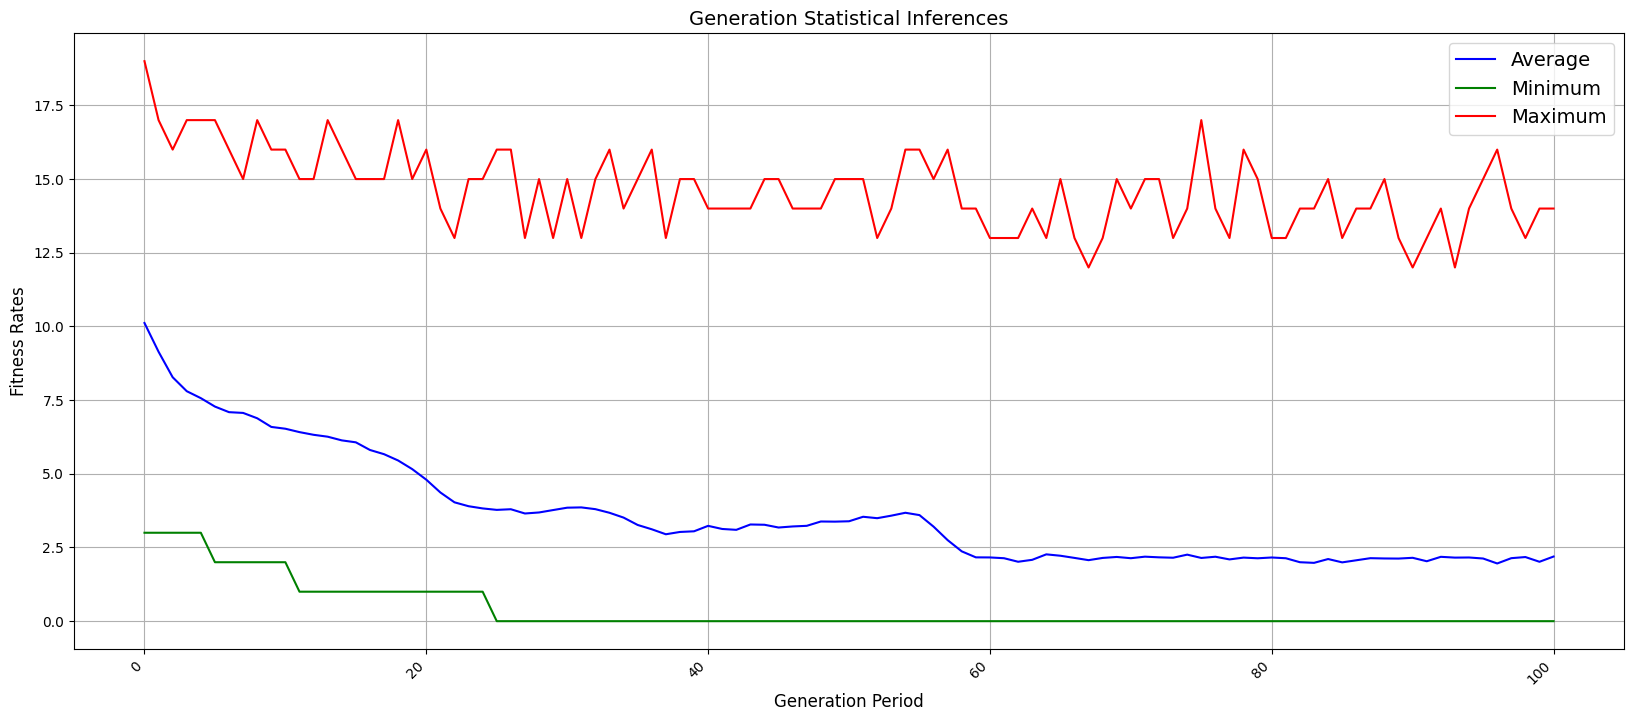

In [106]:
duration, log, fittest_individual = evolution(individual_generator=lambda: random.choices(range(n_queens**2), k=n_queens),
                                              fitness_evaluation=calculate_fitness,
                                              population_size = 2500,
                                              generations = 100,
                                              crossover_rate = .5,
                                              mutation_rate = .5,
                                              mutation_function=(tools.mutUniformInt, {"low": 0, "up": 8**2 - 1, "indpb": 1/4}))


print(f"Computed in {duration:.4f} seconds")
plotting_generations(*log.select("gen", "avg", "min", "max"))

In [107]:
def display_grid(individual: List[int]):
    dimension = len(individual)

    board = pd.DataFrame("", index = range(1, dimension + 1), columns = range(1, dimension + 1))

    # draw conflicts with a red line
    for x in range(dimension):
        x_row, x_column = individual[x] // dimension, individual[x] % dimension
        for y in range(x + 1, dimension):
            y_row, y_column = individual[y] // dimension, individual[y] % dimension

            diff_row, diff_column = y_row - x_row, y_column - x_column
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                for i in range(1 + max(abs(diff_row), abs(diff_column))):
                    board[1 + x_column + i * np.sign(diff_column)][1 + x_row + i * np.sign(diff_row)] = "🤬"

    # draw all queens
    for queen in individual:
        row, column = queen // dimension, queen % dimension
        if board[1 + column][1 + row] == "":
          board[1 + column][1 + row] = "🤴"
        else:
          board[1 + column][1 + row] = "♕"

    display(board)

In [108]:
print(f"Positions: {fittest_individual}")
print(f"Duplicate queens: {len(fittest_individual) - len(set(fittest_individual))}")
print(f"Fitness: {abs(fittest_individual.fitness.values[0])}")
display_grid(fittest_individual)

Positions: [44, 39, 24, 61, 19, 9, 6, 50]
Duplicate queens: 0
Fitness: 0.0


,1,2,3,4,5,6,7,8
1,,,,,,,🤴,
2,,🤴,,,,,,
3,,,,🤴,,,,
4,🤴,,,,,,,
5,,,,,,,,🤴
6,,,,,🤴,,,
7,,,🤴,,,,,
8,,,,,,🤴,,


### **Conclusion**


Therefore, genetic algorithms (GAs) are a practical tool in artificial intelligence because of their adaptability and versatility, allowing for exploring and optimizing solutions in various domains. Implementing a genetic algorithm for solving the 8 queen problem exhibits the efficiency of evolutionary computation methods, highlighting the ability to provide optimized solutions to complex problems.
